In [26]:
import numpy as np
import matplotlib.pyplot as plt

This notebook analyzes the algorithms from Chapter 1 in *Probability and Computing* (Mitzenmacher & Upfal). The motivation for analyzing these algorithms is to introduce probability theory and probabilistic computations.

### Polynomial Checking
Given two polynomials $F(x)$ and $G(x)$, our objective is to create a probabilistic algorithm to check $F(x) \equiv G(x)$, assuming that $x \exists \mathbb{Z}$, and the degrees of $F(x)$ and $G(x)$ have the same degree. We treat the two polynomials as a black box, as we are focused on the analysis.

In [27]:
DEGREE = 6

def F(x: int):
    return 2 * np.prod(x - np.arange(1, 7))

def G(x: int):
    return (x**6) - 21*(x**5) + 175*(x**4) - 735*(x**3) + 1624*(x**2) - 1764*x + 720

In [28]:
def polynomial_check(N: int, d: int):
    # Random uniform sample
    r = np.random.randint(1, (N*d))

    return 1 if F(r) == G(r) else 0

In [29]:
B = 5_000 # Number of simulations
N = 100   # Maximum int range of random sample
eq = 0    # Tracks when F(r)=G(r)

for _ in range(B):
    eq += polynomial_check(N, DEGREE)

p_failure = 100 * (eq / B)
print(f"Estimated P(alg. fails) = {round(p_failure, 6)}%")

Estimated P(alg. fails) = 0.96%


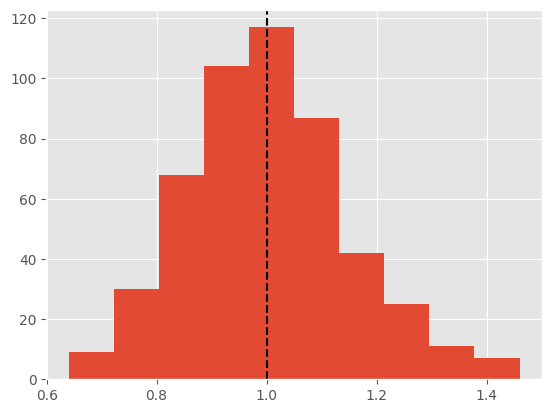

In [30]:
N_REPS = 500
p_failures = [0] * N_REPS

for i in range(N_REPS):
    eq = 0
    for _ in range(B):
        eq += polynomial_check(N, DEGREE)

    p_fail = 100 * (eq / B)
    p_failures[i] = p_fail

# Histogram of simulations
plt.style.use("ggplot")
plt.hist(p_failures, bins=10)
plt.axvline(x=(100 * (1/100)), color="black", linestyle="--")
plt.show()